In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [3]:
engine= create_engine('sqlite:///mta_data.db')
engine.table_names()

['mta_data']

In [4]:
df_20211026=pd.read_sql('SELECT * FROM mta_data where DATE in ("10/25/2021","10/26/2021","10/27/2021");',engine)

In [5]:
#clean data
df_20211026.columns = [column.strip() for column in df_20211026.columns]
df_20211026["DATE_TIME"] = pd.to_datetime(df_20211026.DATE + " " + df_20211026.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [6]:
#check for any duplicate rows
(df_20211026
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-10-25 00:00:00,1
59913,R138,R293,00-00-03,34 ST-PENN STA,2021-10-25 14:00:00,1
60153,R138,R293,00-05-00,34 ST-PENN STA,2021-10-26 14:00:00,1
60152,R138,R293,00-05-00,34 ST-PENN STA,2021-10-26 10:00:00,1
60151,R138,R293,00-05-00,34 ST-PENN STA,2021-10-26 06:00:00,1


In [7]:
#remove duplicate rows
df_20211026.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=True)
df_20211026.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)    


In [8]:
#what is the total entries/exits for a timestamp at a turnstile
df_20211026[["PREV_DATE_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (df_20211026
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
df_20211026.head()


/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_1037/1447392758.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_20211026[["PREV_DATE_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (df_20211026


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,00:00:00,REGULAR,7656685,2623022,2021-10-25 00:00:00,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,04:00:00,REGULAR,7656687,2623023,2021-10-25 04:00:00,2021-10-25 00:00:00,7656685.0,2623022.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,08:00:00,REGULAR,7656702,2623104,2021-10-25 08:00:00,2021-10-25 04:00:00,7656687.0,2623023.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,12:00:00,REGULAR,7656741,2623316,2021-10-25 12:00:00,2021-10-25 08:00:00,7656702.0,2623104.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,16:00:00,REGULAR,7656862,2623364,2021-10-25 16:00:00,2021-10-25 12:00:00,7656741.0,2623316.0


In [9]:
# Drop the rows for the earliest date_time stamp in the df
df_20211026.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)
df_20211026.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,04:00:00,REGULAR,7656687,2623023,2021-10-25 04:00:00,2021-10-25 00:00:00,7656685.0,2623022.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,08:00:00,REGULAR,7656702,2623104,2021-10-25 08:00:00,2021-10-25 04:00:00,7656687.0,2623023.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,12:00:00,REGULAR,7656741,2623316,2021-10-25 12:00:00,2021-10-25 08:00:00,7656702.0,2623104.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,16:00:00,REGULAR,7656862,2623364,2021-10-25 16:00:00,2021-10-25 12:00:00,7656741.0,2623316.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/25/2021,20:00:00,RECOVR AUD,7657024,2623408,2021-10-25 20:00:00,2021-10-25 16:00:00,7656862.0,2623364.0


In [10]:
def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_20211026["TIMEBLOCK_ENTRIES"] = df_20211026.apply(get_counts, axis=1, max_counter=10000)

393218 913.0
393216 3.0
61824 1799.0
1840 61824.0
83198 178651.0
178651 83198.0
54556 178898.0
178898 54556.0
54556 178898.0
178939 54556.0
918332 1906874.0
12 860645.0


In [11]:
#calculate counts for exits

def get_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df_20211026["TIMEBLOCK_EXITS"] = df_20211026.apply(get_counts, axis=1, max_counter=10000)

32455 747.0
765 32455.0
22222 153427.0
153430 22222.0
127015 153581.0
153588 127015.0
127019 153588.0
153597 127019.0
584 1330459.0
2 672021.0


In [12]:
#group turnstiles by station & calculate the total
station_df = df_20211026.groupby(["STATION", "DATE","TIME","DATE_TIME"]).agg({'TIMEBLOCK_ENTRIES':'sum','TIMEBLOCK_EXITS':'sum'}).reset_index()
station_df["TIMEBLOCK_TOTALS"]= station_df['TIMEBLOCK_ENTRIES']+station_df['TIMEBLOCK_EXITS']
station_df.head()

,STATION,DATE,TIME,DATE_TIME,TIMEBLOCK_ENTRIES,TIMEBLOCK_EXITS,TIMEBLOCK_TOTALS
0,1 AV,10/25/2021,04:00:00,2021-10-25 04:00:00,139.0,324.0,463.0
1,1 AV,10/25/2021,08:00:00,2021-10-25 08:00:00,714.0,2364.0,3078.0
2,1 AV,10/25/2021,12:00:00,2021-10-25 12:00:00,1809.0,4612.0,6421.0
3,1 AV,10/25/2021,16:00:00,2021-10-25 16:00:00,2884.0,3143.0,6027.0
4,1 AV,10/25/2021,20:00:00,2021-10-25 20:00:00,3356.0,4465.0,7821.0


In [13]:
#import precipitation data
hrly_df = pd.read_csv('hourly_prcp_2021', parse_dates=["time"])
hrly_df =  hrly_df[['time','prcp']]

In [14]:
#rolling sum over 4 h windows to smooth out varying timestamps
roll_data = station_df[["DATE_TIME","STATION","TIMEBLOCK_ENTRIES","TIMEBLOCK_EXITS","TIMEBLOCK_TOTALS"]].set_index('DATE_TIME').sort_index()
roll4h= roll_data.groupby("STATION").rolling('4H').sum().reset_index()

In [15]:
#resample data into 4h bins & add DATE_TIME prev column
resample_df=station_df.groupby("STATION").resample('4H',on="DATE_TIME").sum().reset_index()
resample_df["TIME"]=resample_df['DATE_TIME'].dt.time
resample_df["DATE_TIME_prev"]= resample_df['DATE_TIME'] - pd.to_timedelta(1,'d')

In [16]:
#check
resample_df[resample_df["STATION"] == "PATH NEW WTC"]

,STATION,DATE_TIME,TIMEBLOCK_ENTRIES,TIMEBLOCK_EXITS,TIMEBLOCK_TOTALS,TIME,DATE_TIME_prev
5338,PATH NEW WTC,2021-10-25 04:00:00,328.0,988.0,1316.0,04:00:00,2021-10-24 04:00:00
5339,PATH NEW WTC,2021-10-25 08:00:00,2144.0,11462.0,13606.0,08:00:00,2021-10-24 08:00:00
5340,PATH NEW WTC,2021-10-25 12:00:00,2315.0,5205.0,7520.0,12:00:00,2021-10-24 12:00:00
5341,PATH NEW WTC,2021-10-25 16:00:00,11137.0,3202.0,14339.0,16:00:00,2021-10-24 16:00:00
5342,PATH NEW WTC,2021-10-25 20:00:00,7240.0,1926.0,9166.0,20:00:00,2021-10-24 20:00:00
5343,PATH NEW WTC,2021-10-26 00:00:00,1227.0,383.0,1610.0,00:00:00,2021-10-25 00:00:00
5344,PATH NEW WTC,2021-10-26 04:00:00,329.0,1262.0,1591.0,04:00:00,2021-10-25 04:00:00
5345,PATH NEW WTC,2021-10-26 08:00:00,1636.0,8388.0,10024.0,08:00:00,2021-10-25 08:00:00
5346,PATH NEW WTC,2021-10-26 12:00:00,1890.0,3461.0,5351.0,12:00:00,2021-10-25 12:00:00
5347,PATH NEW WTC,2021-10-26 16:00:00,7219.0,2334.0,9553.0,16:00:00,2021-10-25 16:00:00


In [17]:
#check calc bin calc
station_df[
        (station_df["DATE_TIME"] < "2021-10-25 08:00:00")&
        (station_df["STATION"] == "PATH NEW WTC")
        ].sum()

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_94216/4214173178.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  station_df[


STATION              PATH NEW WTCPATH NEW WTCPATH NEW WTCPATH NEW W...
DATE                 10/25/202110/25/202110/25/202110/25/202110/25/...
TIME                 04:12:0804:21:4204:23:1904:24:2904:25:3904:25:...
TIMEBLOCK_ENTRIES                                                328.0
TIMEBLOCK_EXITS                                                  988.0
TIMEBLOCK_TOTALS                                                1316.0
dtype: object

In [19]:
#merge  dataframes on time to calculate %change
merged_resample = pd.merge(resample_df, 
                        resample_df, 
                        how= 'inner',
                        left_on= ('STATION','DATE_TIME') , 
                        right_on = ('STATION','DATE_TIME_prev')
                        )

merged_resample ['p_delta']= merged_resample["TIMEBLOCK_TOTALS_y"]/  merged_resample["TIMEBLOCK_TOTALS_x"] -1
merged_resample ['delta']= merged_resample["TIMEBLOCK_TOTALS_y"]-merged_resample["TIMEBLOCK_TOTALS_x"]


In [20]:
(merged_resample[merged_resample["DATE_TIME_y"] =="2021-10-27 00:00:00"]
.sort_values("delta",ascending=True).head(20) )


,STATION,DATE_TIME_x,TIMEBLOCK_ENTRIES_x,TIMEBLOCK_EXITS_x,TIMEBLOCK_TOTALS_x,TIME_x,DATE_TIME_prev_x,DATE_TIME_y,TIMEBLOCK_ENTRIES_y,TIMEBLOCK_EXITS_y,TIMEBLOCK_TOTALS_y,TIME_y,DATE_TIME_prev_y,p_delta,delta
2832,JKSN HT-ROOSVLT,2021-10-26,1850.0,3955.0,5805.0,00:00:00,2021-10-25,2021-10-27,1027.0,2474.0,3501.0,00:00:00,2021-10-26,-0.396899,-2304.0
1380,ATL AV-BARCLAY,2021-10-26,3705.0,1915.0,5620.0,00:00:00,2021-10-25,2021-10-27,1631.0,1774.0,3405.0,00:00:00,2021-10-26,-0.394128,-2215.0
610,3 AV-149 ST,2021-10-26,1800.0,1239.0,3039.0,00:00:00,2021-10-25,2021-10-27,439.0,797.0,1236.0,00:00:00,2021-10-26,-0.593287,-1803.0
2370,FLATBUSH AV-B.C,2021-10-26,293.0,757.0,1050.0,00:00:00,2021-10-25,2021-10-27,84.0,206.0,290.0,00:00:00,2021-10-26,-0.723810,-760.0
2392,FLUSHING-MAIN,2021-10-26,2074.0,4460.0,6534.0,00:00:00,2021-10-25,2021-10-27,1898.0,3948.0,5846.0,00:00:00,2021-10-26,-0.105295,-688.0
2601,GUN HILL RD,2021-10-26,234.0,1097.0,1331.0,00:00:00,2021-10-25,2021-10-27,153.0,666.0,819.0,00:00:00,2021-10-26,-0.384673,-512.0
291,170 ST,2021-10-26,294.0,896.0,1190.0,00:00:00,2021-10-25,2021-10-27,222.0,638.0,860.0,00:00:00,2021-10-26,-0.277311,-330.0
2843,JOURNAL SQUARE,2021-10-26,220.0,1098.0,1318.0,00:00:00,2021-10-25,2021-10-27,255.0,791.0,1046.0,00:00:00,2021-10-26,-0.206373,-272.0
2777,JAMAICA CENTER,2021-10-26,830.0,2295.0,3125.0,00:00:00,2021-10-25,2021-10-27,733.0,2125.0,2858.0,00:00:00,2021-10-26,-0.085440,-267.0
104,125 ST,2021-10-26,2328.0,3804.0,6132.0,00:00:00,2021-10-25,2021-10-27,2186.0,3694.0,5880.0,00:00:00,2021-10-26,-0.041096,-252.0


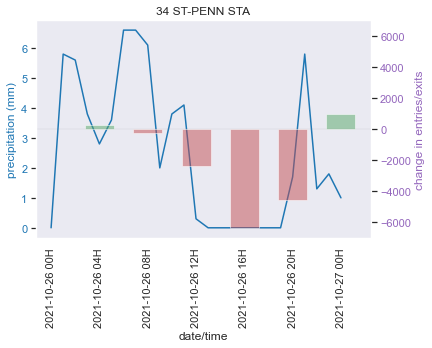

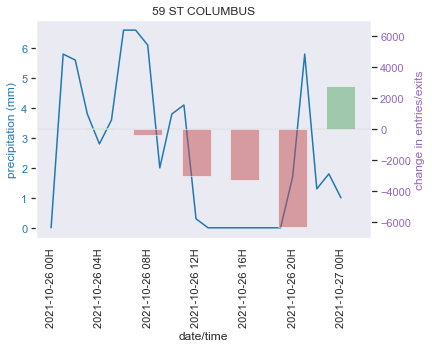

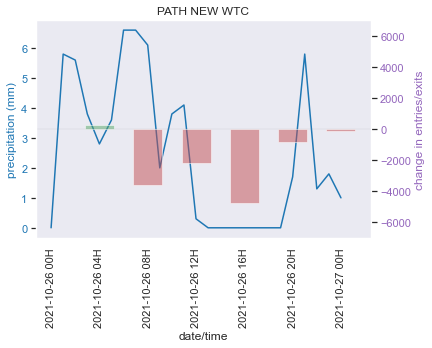

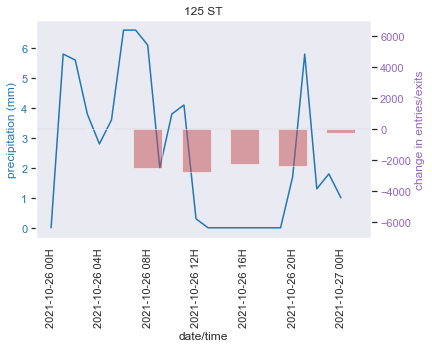

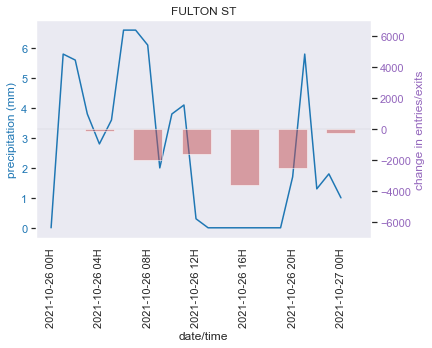

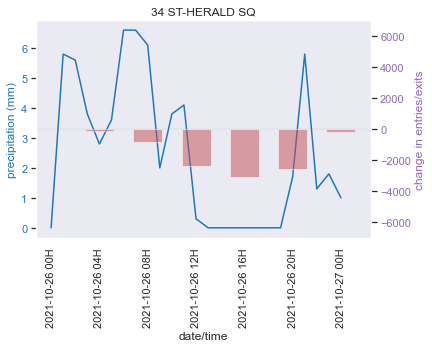

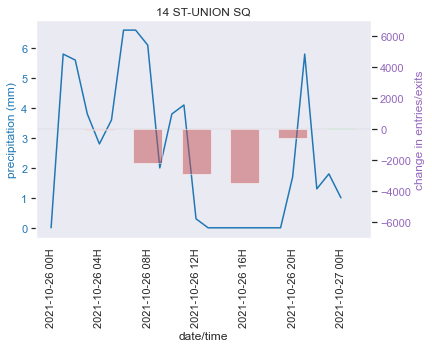

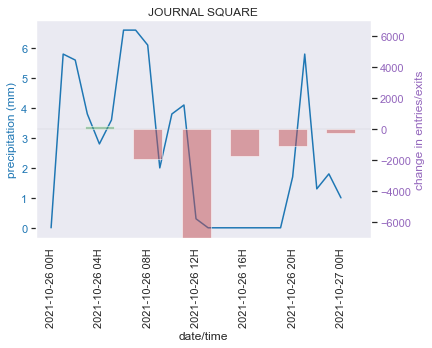

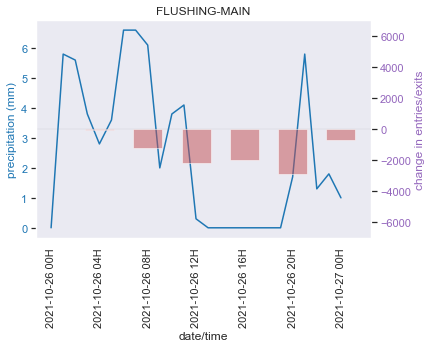

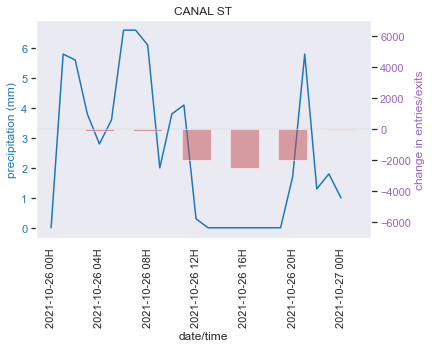

In [45]:
#graphs for decreasing stations

list = ["34 ST-PENN STA","59 ST COLUMBUS","PATH NEW WTC","125 ST","FULTON ST","34 ST-HERALD SQ",
"14 ST-UNION SQ","JOURNAL SQUARE","FLUSHING-MAIN","CANAL ST"]

for i in list:

    prcp_plot = hrly_df.loc[
                (hrly_df["time"]>="2021-10-26 00:00:00") &
                (hrly_df["time"]<="2021-10-27 00:00:00" ) ]

    station_plot=merged_resample.loc[
                (merged_resample["STATION"]==i)& 
                (merged_resample["DATE_TIME_y"]>="2021-10-26 00:00:00") &
                (merged_resample["DATE_TIME_y"]<="2021-10-27 00:00:00" )]
    station_plot
    
    sns.set_theme()
    sns.set_style("dark")

    x= prcp_plot.time
    y= prcp_plot.prcp
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel('date/time')
    ax1.set_ylabel('precipitation (mm)', color=color)
    ax1.plot(x, y, color=color)
    ax1.tick_params(axis ='y' , length = 5, direction = 'out')
    plt.xticks(rotation = 90)
    
    hours = md.HourLocator(byhour=[0,4,8,12,16,20])#interval = 4)
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d %H" +"H"))
    ax1.tick_params(axis='y', labelcolor=color)

    x= station_plot.DATE_TIME_y
    z= station_plot.delta

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:purple'
    ax2.set_ylabel('change in entries/exits', color=color)  # we already handled the x-label with ax1
    ax2.bar(x, z,
            color=(station_plot['delta']>0).map({True:'g', False:'r'}),
        width=0.1,
        alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-7000,7000])

    plt.axhline(y = 0, linewidth= 0.1, color="gray")
    plt.title(i)
    plt.savefig('decreases_20211026_{}.png'.format(list.index(i)))


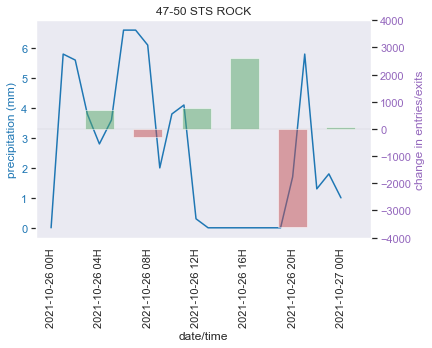

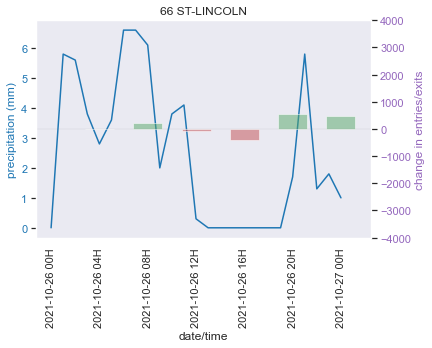

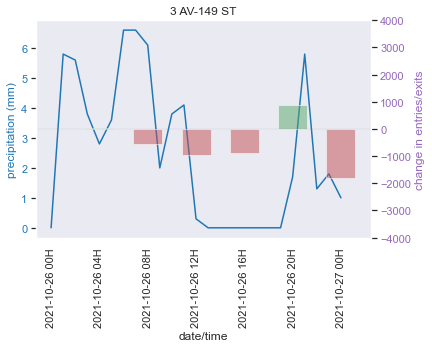

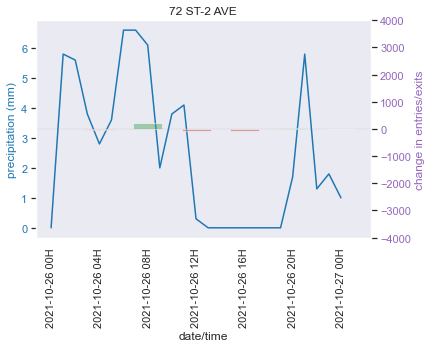

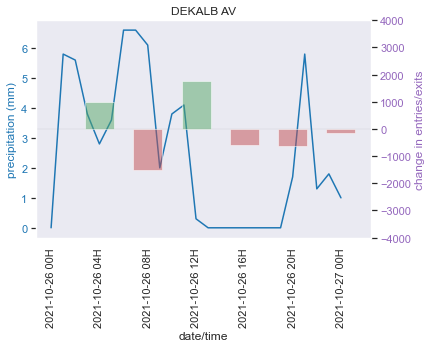

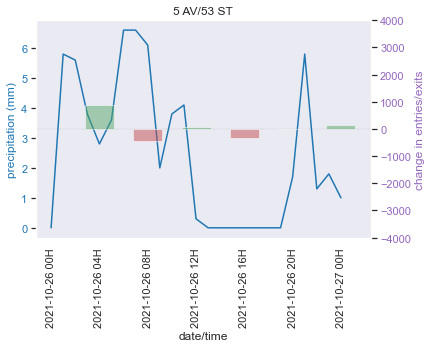

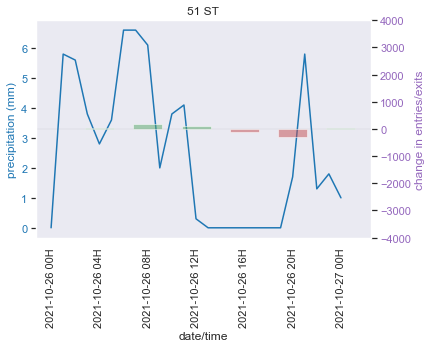

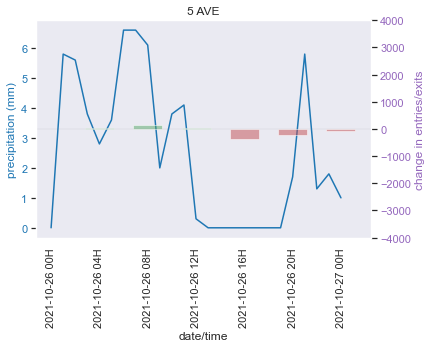

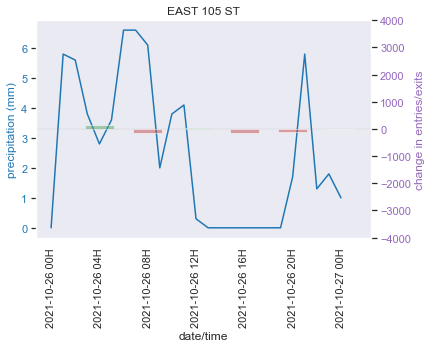

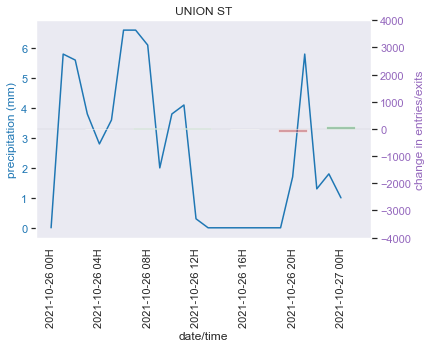

In [44]:
#graphs for increasing stations

list = ["47-50 STS ROCK","66 ST-LINCOLN","3 AV-149 ST","72 ST-2 AVE","DEKALB AV","5 AV/53 ST",
"51 ST","5 AVE","EAST 105 ST","UNION ST"]

for i in list:

    prcp_plot = hrly_df.loc[
                (hrly_df["time"]>="2021-10-26 00:00:00") &
                (hrly_df["time"]<="2021-10-27 00:00:00" ) ]

    station_plot=merged_resample.loc[
                (merged_resample["STATION"]==i)& 
                (merged_resample["DATE_TIME_y"]>="2021-10-26 00:00:00") &
                (merged_resample["DATE_TIME_y"]<="2021-10-27 00:00:00" )]
    station_plot
    
    sns.set_theme()
    sns.set_style("dark")

    x= prcp_plot.time
    y= prcp_plot.prcp
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel('date/time')
    ax1.set_ylabel('precipitation (mm)', color=color)
    ax1.plot(x, y, color=color)
    ax1.tick_params(axis ='y' , length = 5, direction = 'out')
    plt.xticks(rotation = 90)
    
    hours = md.HourLocator(byhour=[0,4,8,12,16,20])#interval = 4)
    plt.gca().xaxis.set_major_locator(hours)
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d %H" +"H"))
    ax1.tick_params(axis='y', labelcolor=color)

    x= station_plot.DATE_TIME_y
    z= station_plot.delta

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:purple'
    ax2.set_ylabel('change in entries/exits', color=color)  # we already handled the x-label with ax1
    ax2.bar(x, z,
            color=(station_plot['delta']>0).map({True:'g', False:'r'}),
        width=0.1,
        alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-4000,4000])

    plt.axhline(y = 0, linewidth= 0.1, color="gray")
    plt.title(i)
    plt.savefig('increases_20211026_{}.png'.format(list.index(i)))
    
